$$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 20165549\ \ JANG\ \ JAE\ \ YONG$$

Build a binary classifier based on 3 layers neural network using the human versus horse dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os
import pandas as pd

transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),
    # the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])

#train_data_path = 'relative path of training data set'
train_data_path = 'horse-or-human/horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=1)  

validation_data_path = 'horse-or-human/horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False, num_workers=1)  

NUM_EPOCH = range(1) # my code

#
# Image size and number of data
#
image_size = 10000
train_count = 1027
validation_count = 256

train_label = np.empty(train_count, dtype=float)
train_data = np.ones((train_count, image_size + 1), dtype=float)

validation_label = np.empty(validation_count, dtype=float)
validation_data = np.ones((validation_count, image_size + 1), dtype=float)

for epoch in (NUM_EPOCH):
    # load training images of the batch size for every iteration
    for i, data in enumerate(trainloader):

        # inputs is the image
        # labels is the class of the image
        inputs, labels = data

        # if you don't change the image size, it will be [batch_size, 1, 100, 100]
        #print(inputs.shape)

        # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
        #print(labels)
        
        train_label[i] = int(labels)
        train_tmp = np.asfarray(inputs)
        train_data[i, :10000] = train_tmp[0, 0, :, :].reshape(10000)
        
    # load validation images of the batch size for every iteration
    for i, data in enumerate(valloader):
        
        # inputs is the image
        # labels is the class of the image
        inputs, labels = data

        # if you don't change the image size, it will be [batch_size, 1, 100, 100]
        #print(inputs.shape)

        # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
        #print(labels)
        
        validation_label[i] = int(labels)
        validation_tmp = np.asfarray(inputs)
        validation_data[i, :10000] = validation_tmp[0, 0, :, :].reshape(10000)

In [11]:
delta = 10**(-9)

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def loss_function(t, y):
    return -np.sum(t*np.log(y+delta) + (1-t)*np.log(1-y+delta)) 

In [12]:
def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def LeakyReLU(x):
    return np.maximum(0.1*x, x)

In [13]:
def ActivationFunc(FunctionName, x):
    
    if FunctionName == 'sigmoid':
        return sigmoid(x)
    elif FunctionName == 'tanh':
        return tanh(x)
    elif FunctionName == 'ReLU':
        return ReLU(x)
    elif FunctionName == 'LeakyReLU':
        return LeakyReLU(x)

In [14]:
def d_ActivationFunc(FunctionName, x):
    
    if FunctionName == 'sigmoid':
        return sigmoid(x) * (1 - sigmoid(x))
    elif FunctionName == 'tanh':
        return 1 - (tanh(x))**2
    elif FunctionName == 'ReLU':
        return 1. * (x > 0)
    elif FunctionName == 'LeakyReLU':
        return 1. * (xa > 0) + 0.1 * (xa < 0)

In [31]:
def ThreeLayerNeuralNetwork(FuncName):
    
    learningRate = 10**(-3) # learningRate
    
    uc = 100   # u
    vc = 10   # v
    wc = 1    # w
    
    u = np.ones((image_size + 1, uc + 1), dtype=float)
    v = np.ones((uc + 1, vc + 1), dtype=float)
    w = np.ones((vc + 1, wc + 1), dtype=float)

    a = np.ones((train_count, uc + 1), dtype=float)
    b = np.ones((train_count, vc + 1), dtype=float)
    c = np.ones((train_count, wc), dtype=float)
    h = np.ones((train_count, wc), dtype=float)

    t_a = np.ones((train_count, uc + 1), dtype=float)
    t_b = np.ones((train_count, vc + 1), dtype=float)
    t_c = np.ones((train_count, wc), dtype=float)
    t_h = np.ones((train_count, wc), dtype=float)
    
    iteration = 2000 # Max Iteration
    loss_arr = np.zeros(iteration, dtype=float)
    t_loss_arr = np.zeros(iteration, dtype=float)
    loss_value_arr = np.zeros(iteration, dtype=float)
    t_loss_value_arr = np.zeros(iteration, dtype=float)

    u[:-1, :-1] = np.random.randn(image_size, uc) / np.sqrt(image_size+1)
    u[image_size, :-1] = np.random.rand(uc)
    v[:-1, :-1] = np.random.randn(uc, vc) / np.sqrt(uc+1)
    v[uc, :-1] = np.random.rand(vc)
    w[:-1, :-1] = np.random.randn(vc, wc) / np.sqrt(vc+1)
    w[vc, :-1] = np.random.rand(wc)
    d_lc = np.empty(train_count, dtype=float)
    d_cb = np.empty(train_count, dtype=float)
    d_ba = np.empty(train_count, dtype=float)
    
    for iter in range(iteration):
        #
        # training matrix
        for i in range(train_count): # u * X
            for j in range(uc):
                a[i, j] = (train_data[i, :]).dot(u[:, j])

        for i in range(train_count): # v * ActivationFunc(a)
            for j in range(vc):
                b[i, j] = (ActivationFunc(FuncName, a[i, :])).dot(v[:, j])

        for i in range(train_count): # w * ActivationFunc(b)
            for j in range(wc):
                c[i, j] = (ActivationFunc(FuncName, b[i, :])).dot(w[:, j])

        h[:, :] = sigmoid(c[:, :]) # sigmoid(c)

        #
        # validation matrix for loss value calculation
        for i in range(validation_count):
            for j in range(uc):
                t_a[i, j] = (validation_data[i, :]).dot(u[:, j])

        for i in range(validation_count):
            for j in range(vc):
                t_b[i, j] = (ActivationFunc(FuncName, t_a[i, :])).dot(v[:, j])

        for i in range(validation_count):
            for j in range(wc):
                t_c[i] = (ActivationFunc(FuncName, t_b[i, :])).dot(w[:, j])

        t_h[:, :] = sigmoid(t_c[:, :])

        for i in range(train_count):
            d_lc[i] = np.mean(h[i, :]) - train_label[i]

        for i in range(train_count):
            d_ba[i] = np.mean(ActivationFunc(FuncName, a[i, :-1]))

        for i in range(train_count):
            d_cb[i] = np.mean(ActivationFunc(FuncName, b[i, :-1]))

        for i in range(image_size):
            u[i, :-1] = u[i, :-1] - learningRate * np.mean(d_lc[:] * d_cb[:] * d_ba[:] * train_data[:, i])
        u[image_size, :-1] = u[image_size, :-1] - learningRate * np.mean(d_lc[:] * d_cb[:] * d_ba[:])

        for i in range(uc):
            v[i, :-1] = v[i, :-1] - learningRate * np.mean(d_lc[:] * d_cb[:] * ActivationFunc(FuncName, a[:, i]))
        v[uc, :-1] = v[uc, :-1] - learningRate * np.mean(d_lc[:] * d_cb[:])

        for i in range(vc):
            w[i, :] = w[i, :] - learningRate * np.mean(d_lc[:].dot(ActivationFunc(FuncName, b[:, i])))
        w[vc, :] = w[vc, :] - learningRate * np.mean(d_lc[:])

        loss_value = 0
        t_loss_value = 0
        training_loss = 0
        testing_loss = 0

        for i in range(train_count):
            loss_value += loss_function(train_label[i], np.mean(h[i, :]))

            if train_label[i] == 1:
                if np.mean(h[i, :]) <= 0.5: # loss count
                    training_loss += 1
            else:
                if np.mean(h[i, :]) > 0.5: # loss count
                    training_loss += 1
        
        if loss_value < 0.1:
            break
        
        for i in range(validation_count):
            t_loss_value += loss_function(validation_label[i], np.mean(t_h[i, :]))
            if validation_label[i] == 1:
                if np.mean(t_h[i, :]) <= 0.5: # loss count
                    testing_loss += 1
            else:
                if np.mean(t_h[i]) > 0.5: # loss count
                    testing_loss += 1

        if iter % 100 == 0 or iter+1 == iteration:                           ###
            print("iter =", iter)                                               ##
            print("train loss count =", training_loss)                           ##
            print("train loss value =", loss_value / train_count)                ##
            print("validation loss count =", testing_loss)                       ##
            print("validation loss value =", t_loss_value / validation_count)   ##

        loss_value_arr[iter] = loss_value
        t_loss_value_arr[iter] = t_loss_value
        loss_arr[iter] = training_loss
        t_loss_arr[iter] = testing_loss
        
        
    return loss_value_arr, loss_arr, t_loss_value_arr, t_loss_arr

In [32]:
def LossPlot(FuncName):
    x = range(iteration)
    y1 = loss_value_arr[x] / train_count
    y2 = t_loss_value_arr[x] / validation_count

    plt.plot(x, y1, "BLUE")
    plt.plot(x, y2, "RED")
    plt.title(FuncName + ' Training and Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()

In [33]:
def AccuracyPlot(FuncName):
    x = range(iteration)
    y1 = (train_count - loss_arr[x]) / train_count
    y2 = (validation_count - t_loss_arr[x]) / validation_count

    plt.plot(x, y1, "BLUE")
    plt.plot(x, y2, "RED")
    plt.title(FuncName + ' Training and Validation Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy percent')
    plt.show()

In [34]:
def Loss_And_Accuracy_Table(FuncName):
    print(FuncName + ' Loss and Accuracy Table')
    idx1 = round(loss_value_arr[iteration - 1] / train_count, 6)
    idx2 = str(round((train_count - loss_arr[iteration - 1]) / train_count * 100, 2)) + ' %'
    idx3 = round(t_loss_value_arr[iteration - 1] / validation_count, 6)
    idx4 = str(round((validation_count - t_loss_arr[iteration - 1]) / validation_count * 100, 2)) + ' %'

    df = pd.DataFrame(data=np.array([[idx1, idx2], [idx3, idx4]]), index= ['Training', 'Validation'], columns=['Loss', 'Accuracy'])
    display(df)

In [ ]:
ThreeLayerNeuralNetwork('sigmoid')
LossPlot('sigmoid')
AccuracyPlot('sigmoid')
Loss_And_Accuracy_Table('sigmoid')

iter = 0
train loss count = 500
train loss value = 0.8198964457355868
validation loss count = 128
validation loss value = 0.8312344440604057
iter = 100
train loss count = 500
train loss value = 0.6920504611754736
validation loss count = 128
validation loss value = 0.6935252578325926


In [ ]:
ThreeLayerNeuralNetwork('tanh')
LossPlot('tanh')
AccuracyPlot('tanh')
Loss_And_Accuracy_Table('tanh')

In [ ]:
ThreeLayerNeuralNetwork('ReLU')
LossPlot('ReLU')
AccuracyPlot('ReLU')
Loss_And_Accuracy_Table('ReLU')

In [ ]:
ThreeLayerNeuralNetwork('LeakyReLU')
LossPlot('LeakyReLU')
AccuracyPlot('LeakyReLU')
Loss_And_Accuracy_Table('LeakyReLU')

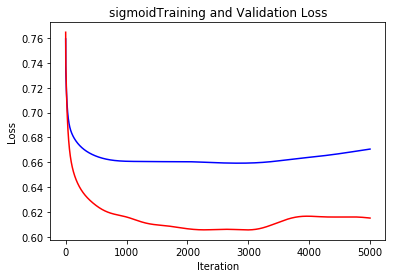

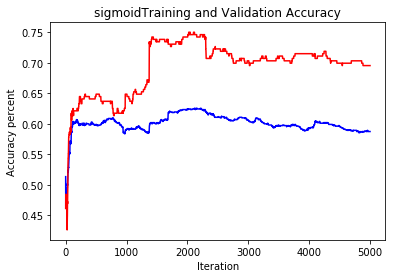

sigmoidLoss and Accuracy Table


,Loss,Accuracy
Training,0.670634,58.71 %
Validation,0.615124,69.53 %


In [54]:
LossPlot('sigmoid')
AccuracyPlot('sigmoid')
Loss_And_Accuracy_Table('sigmoid')

MarkDown :

| Dataset | Loss | Accuracy |
|:--------|:--------:|--------:|
| Training | 0.670634 | 58.71% |
| Validation | 0.615124 | 69.53% |